 # Simple linear models

In [21]:
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#import cartopy.crs as ccrs*
import numpy as np
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns
import xarray as xr
import scipy

save_dir = '/home/hanna/images_simple_statsmodels/'
#from utils.saverRestorer import SaverRestorer. Hvordan fikser jeg dette Severin

In [22]:
def load_data(start = "2012-01-01", stop = "2018-01-01", lat_idx = 15, lon_idx = 30):
    #glob.glob(era_path + "*_all_cropped.nc")
    era_path = '/home/hanna/lagrings/era_interim_data/'
    assert len(glob.glob(era_path + "*_q_all_cropped.nc")), "no data run cnct_lh in bash"
    q   = xr.open_dataset(glob.glob(era_path + '*_q_all_cropped.nc')[0]).sel(time = slice(start, stop)).q.values
    r   = xr.open_dataset(glob.glob(era_path + "*_r_all_cropped.nc")[0]).sel(time = slice(start, stop)).r.values
    tcc = xr.open_dataset(glob.glob(era_path + "*_tcc_all_cropped.nc")[0]).sel(time = slice(start, stop)).tcc.values
    sp  = xr.open_dataset(glob.glob(era_path + "*_sp_all_cropped.nc")[0]).sel(time = slice(start, stop)).sp.values
    t2m = xr.open_dataset(glob.glob(era_path + "*_t2m_all_cropped.nc")[0]).sel(time = slice(start, stop)).t2m.values
    assert np.shape(q) == np.shape(r) == np.shape(tcc) == np.shape(sp) == np.shape(t2m)
    
    nbr_times, nbr_lats, nbr_lon = np.shape(q)
    
    train = []
    true  = tcc[:,lat_idx, lon_idx]

    for i in range(nbr_times):
        one_timestep = np.array([q[i][lat_idx][lon_idx], r[i][lat_idx][lon_idx], 
                                 sp[i][lat_idx][lon_idx], t2m[i][lat_idx][lon_idx]])
                                 
        train.append(one_timestep)

    return np.array(train), true

In [25]:
from scipy.optimize import curve_fit

def fit_func_0ts(x, a, b, c, d, e):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3]

def fit_func_1ts(x, a, b, c, d, e, f):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3] + f*x[4]

def fit_func_2ts(x, a, b, c, d, e, f, g):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3] + f*x[4] + g*x[5] 

def fit_func_3ts(x, a, b, c, d, e, f, g, h):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3] + f*x[4] + g*x[5] + h*x[6] 

def fit_func_4ts(x, a, b, c, d, e, f, g, h, i):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3] + f*x[4] + g*x[5] + h*x[6]  + i*x[7]

def fit_func_5ts(x, a, b, c, d, e, f, g, h, i, j):
    # a, b, c, d, e - always needed
    # ydata = f(xdata, *params) + eps
    return a + b*x[0] + c*x[1] + d*x[2] + e*x[3] + f*x[4] + g*x[5] + h*x[6] + i*x[7] + j*x[8]

def predict(popt, train):
    return popt[0] + np.dot(popt[1:], train)

def generate_input(x, y, number_ts = 1):
    
    train = np.zeros((4 + number_ts, len(y) - number_ts))
    for i in range(number_ts, len(y)):
        j = i - number_ts
        if number_ts > 0:
            train[:, j] = np.concatenate([x[i, :], y[j : i]])
        else:
            train[:, j] = x[i, :]
    return train, y[number_ts:] # Removes the n first history.

def mse(test, train, popt):
    return np.mean(np.square(test - predict(popt, train)))


def plot_heatmap(train, test, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.5))
    sns.heatmap(train, ax = ax1)
    sns.heatmap(test, ax = ax2)
    plt.savefig(save_dir + "{}.png".format(title))
    return 

In [ ]:
def train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 1, func = fit_func_1ts):
    
    result_train = np.zeros((len(lats), len(lons)))
    result_test = np.zeros((len(lats), len(lons)))
    
    for i, la in enumerate(lats):
        for j, lo in enumerate(lons):
            x_data_train, y_data_train = load_data(start = "2012-01-01", 
                                                   stop = "2018-01-01",
                                                   lat_idx = la, 
                                                   lon_idx = lo)
            
            assert len(x_data_train) == (y_data_train) == 0
            
            x_data_test, y_data_test = load_data(start = "2018-01-01", 
                                                 stop = "2019-01-01", 
                                                 lat_idx = la, 
                                                 lon_idx = lo)
            assert len(x_data_test) == (y_data_test) == 0

            train, test = generate_input(x_data_train, y_data_train, number_ts=number_ts)
            
            print('{}-{}'.format(train.shape, test.shape))
            popt, pcov = curve_fit(func, train, test)
            result_train[i][j] = mse(test, train, popt)
            
            train, test = generate_input(x_data_test, y_data_test, number_ts=number_ts)
            
            print('{}-{}'.format(train.shape, test.shape))
            result_test[i][j] = mse(test, train, popt)
        #print('passed lon {} lat {}'.format(la, lo))
    return result_train, result_test

In [28]:
tr, te = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 1, func = fit_func_1ts)

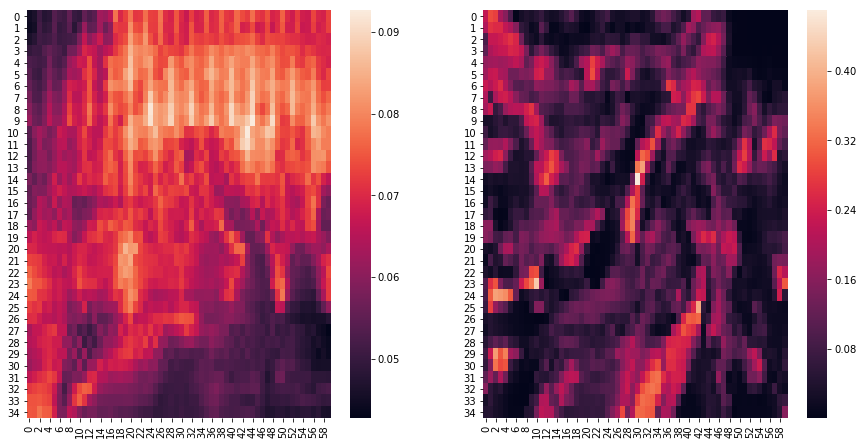

In [29]:
plot_heatmap(tr, te, 'simple_stats_1ts')

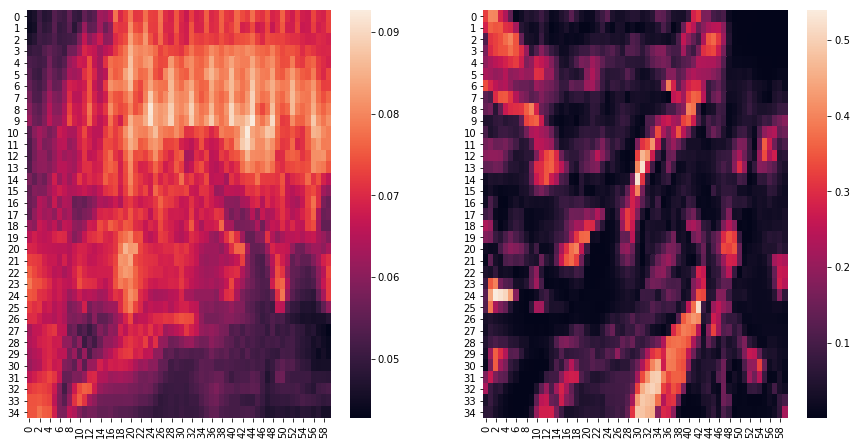

In [30]:
tr2, te2 = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 2, func = fit_func_2ts)
plot_heatmap(tr2, te2, 'simple_stats_2ts')

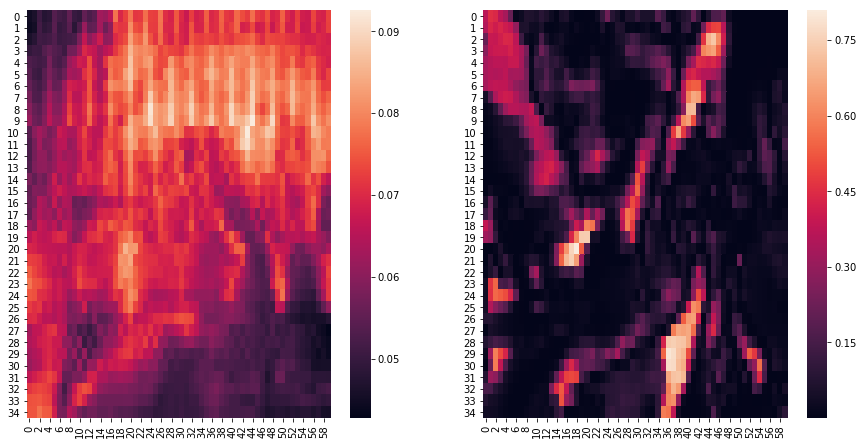

In [31]:
tr3, te3 = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 3, func = fit_func_3ts)
plot_heatmap(tr3, te3, 'simple_stats_3ts')

In [ ]:
tr4, te4 = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 4, func = fit_func_4ts)
plot_heatmap(tr4, te4, 'simple_stats_4ts')

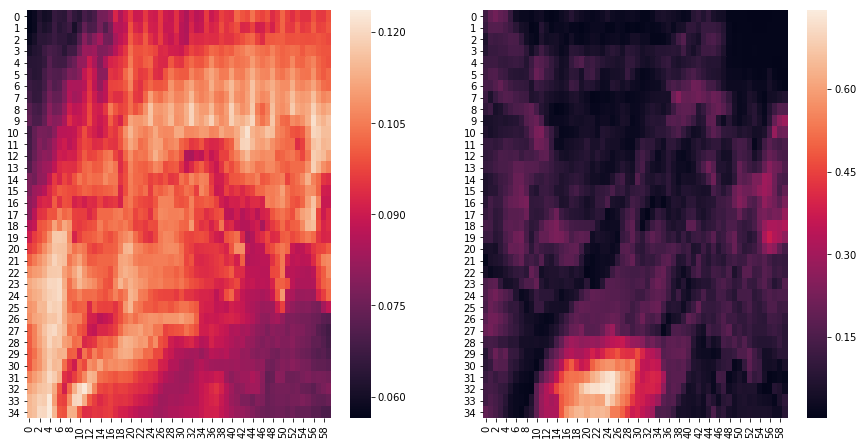

In [39]:
tr0, te0 = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 0, func = fit_func_0ts)
plot_heatmap(tr0, te0, 'simple_stats_0ts')

In [40]:
tr5, te5 = train_test(lats = np.arange(35), lons = np.arange(60), number_ts = 5, func = fit_func_5ts)
plot_heatmap(tr5, te5, 'simple_stats_5ts')

ValueError: negative dimensions are not allowed

In [17]:
# plot the differences of the tests check if it exactly the same.

In [1]:
#sns.heatmap(np.abs(te - te3))